In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['patch.linewidth'] = 2
%matplotlib inline

In [2]:
from read_dataset import *

In [3]:
# dict for indexing data columns
ind = {}
ind['run'] = 0
ind['event'] = 1
ind['Ncharged'] = 2
ind['Pcharged'] = 3
ind['E_ecal'] = 4
ind['E_hcal'] = 5
ind['E_lep'] = 6
ind['cos_thru'] = 7
ind['cos_thet'] = 8

In [4]:
data = {}
data['ee'] = read_dataset('data/MonteCarlo/ee.csv')
data['mm'] = read_dataset('data/MonteCarlo/mm.csv')
data['tt'] = read_dataset('data/MonteCarlo/tt.csv')
data['qq'] = read_dataset('data/MonteCarlo/qq.csv')

In [5]:
data_ee_presel = list(filter(lambda x: abs(x[ind['cos_thet']]) <= 0.7, data['ee']))
print('Events in [0,0.7]:', len(list(filter(lambda x: x[ind['cos_thet']] >= 0, data_ee_presel))))
print('Events in [-0.7,0):', len(list(filter(lambda x: x[ind['cos_thet']] < 0, data_ee_presel))))

Events in [0,0.7]: 11789
Events in [-0.7,0): 9620


In [6]:
# get number of s-channel events
data_ee_s = list(filter(lambda x: x[ind['cos_thet']] <= 0.0296, data_ee_presel))
print(len(data_ee_s))

10009


In [7]:
def select_ee(event):
    # preselection: no good data from these angles
    if abs(event[ind['cos_thet']]) > 0.7: return False
    
    # exclude t-channel events
    if event[ind['cos_thet']] > 0.0296: return False
    
    # qq
    if event[ind['Ncharged']] > 4: return False
    
    # mm, tt
    if event[ind['E_ecal']] < 60: return False
    
    # accept the rest
    return True

print(len(list(filter(select_ee, data['ee']))))
print(len(list(filter(select_ee, data['mm']))))
print(len(list(filter(select_ee, data['tt']))))
print(len(list(filter(select_ee, data['qq']))))

10007
1
478
0


In [8]:
def select_mm(event):
    # qq
    if event[ind['Ncharged']] != 2 : return False
    
    # ee
    if event[ind['E_ecal']] > 30: return False
    
    # tt
    if event[ind['Pcharged']] < 60: return False
    
    #tt
    if event[ind['E_hcal']] > 15 : return False
    
    return True

print(len(list(filter(select_mm, data['ee']))))
print(len(list(filter(select_mm, data['mm']))))
print(len(list(filter(select_mm, data['tt']))))
print(len(list(filter(select_mm, data['qq']))))

0
85546
583
0


In [9]:
data_mm_selected = list(filter(select_mm, data['mm']))
print('Events in [0,1]:', len(list(filter(lambda x: x[ind['cos_thet']] >= 0, data_mm_selected))))
print('Events in [-1,0):', len(list(filter(lambda x: x[ind['cos_thet']] < 0, data_mm_selected))))

Events in [0,1]: 44154
Events in [-1,0): 41392


In [10]:
def select_tt(event):
    # qq
    if event[ind['Ncharged']] > 7 or event[ind['Ncharged']] < 2 : return False
    
    # ee
    if event[ind['E_ecal']] > 45: return False
    
    # mm
    if event[ind['Pcharged']] > 40 : return False
    
    #mm
    if event[ind['Ncharged']] == 2  : return False
    
    return True

print(len(list(filter(select_tt, data['ee']))))
print(len(list(filter(select_tt, data['mm']))))
print(len(list(filter(select_tt, data['tt']))))
print(len(list(filter(select_tt, data['qq']))))

0
162
10943
424


In [11]:
def select_qq(event):
    # ee, mm, tt
    if event[ind['Ncharged']] < 8: return False
    
    # ee, mm, tt
    if event[ind['E_ecal']] < 30 or event[ind['E_ecal']] > 80: return False
    
    return True

print(len(list(filter(select_qq, data['ee']))))
print(len(list(filter(select_qq, data['mm']))))
print(len(list(filter(select_qq, data['tt']))))
print(len(list(filter(select_qq, data['qq']))))

0
0
399
95545


In [12]:
# numbers of selected events
sel = {}

sel['ee'] = len(list(filter(select_ee, data['ee'])))
sel['em'] = len(list(filter(select_ee, data['mm'])))
sel['et'] = len(list(filter(select_ee, data['tt'])))
sel['eq'] = len(list(filter(select_ee, data['qq'])))

sel['me'] = len(list(filter(select_mm, data['ee'])))
sel['mm'] = len(list(filter(select_mm, data['mm'])))
sel['mt'] = len(list(filter(select_mm, data['tt'])))
sel['mq'] = len(list(filter(select_mm, data['qq'])))

sel['te'] = len(list(filter(select_tt, data['ee'])))
sel['tm'] = len(list(filter(select_tt, data['mm'])))
sel['tt'] = len(list(filter(select_tt, data['tt'])))
sel['tq'] = len(list(filter(select_tt, data['qq'])))

sel['qe'] = len(list(filter(select_qq, data['ee'])))
sel['qm'] = len(list(filter(select_qq, data['mm'])))
sel['qt'] = len(list(filter(select_qq, data['tt'])))
sel['qq'] = len(list(filter(select_qq, data['qq'])))

In [13]:
# set options for numpy printing
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)

In [14]:
# create numpy array with all selection combinations
sel_np = np.zeros((4,4))

# convert dictionary to numpy array (for later calculation)
for index_s, s in enumerate('emtq'):
    for index_c, c in enumerate('emtq'):
        sel_np[index_s, index_c] = sel[s+c]
print(sel_np)

[[10007.     1.   478.     0.]
 [    0. 85546.   583.     0.]
 [    0.   162. 10943.   424.]
 [    0.     0.   399. 95545.]]


In [15]:
# number of real events (before selection)
Ngen = [29979, len(data['mm']), len(data['tt']), len(data['qq'])]


eff = np.zeros((4,4))
# calculate efficiencies
for selection in range(4):
    for channel in range(4):
        eff[selection,channel] = sel_np[selection,channel] / Ngen[channel]

print("Efficiency matrix:")
print(eff)
    
# calculate errors for efficiency matrix
eff_error = np.zeros((4,4))
for selection in range(4):
    for channel in range(4):
        eff_error[selection, channel] = np.sqrt((eff[selection, channel] * (1 - eff[selection, channel])) / Ngen[channel])
        
print("Errors for efficiency matrix:")
print(eff_error)

Efficiency matrix:
[[0.3338 0.     0.006  0.    ]
 [0.     0.9064 0.0074 0.    ]
 [0.     0.0017 0.1381 0.0043]
 [0.     0.     0.005  0.9694]]
Errors for efficiency matrix:
[[0.0027 0.     0.0003 0.    ]
 [0.     0.0009 0.0003 0.    ]
 [0.     0.0001 0.0012 0.0002]
 [0.     0.     0.0003 0.0005]]


In [16]:
# Invert efficiency matrix
eff_inv = np.linalg.inv(eff)
print("Inverted efficienzy matrix")
print(eff_inv)

# Calculate errors for invertet efficiecny matrix (if diagonal elements = 0)
eff_inv_err = np.zeros((4,4))

for i in range(4):
    eff_inv_err[i,i] = 1 / eff[i,i]**2 * eff_error[i,i]
print("Errors for inverted efficiency matrix:")
print(eff_inv_err)

Inverted efficienzy matrix
[[ 2.9958  0.0002 -0.1309  0.0006]
 [ 0.      1.1034 -0.0588  0.0003]
 [ 0.     -0.0137  7.2407 -0.0321]
 [ 0.      0.0001 -0.0376  1.0318]]
Errors for inverted efficiency matrix:
[[0.0244 0.     0.     0.    ]
 [0.     0.0012 0.     0.    ]
 [0.     0.     0.0642 0.    ]
 [0.     0.     0.     0.0006]]


In [17]:
lep_data = {}
lep_data[0] = read_dataset('data/daten_3.csv')

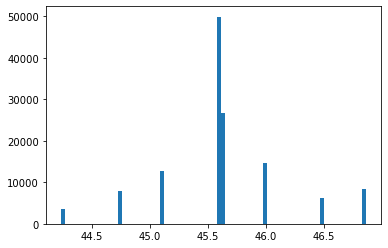

In [18]:
plt.hist(lep_data[0][:,ind['E_lep']], bins=80, histtype='stepfilled');

In [19]:
lep_data[1] = np.array(list(filter(lambda x:        x[ind['E_lep']] < 44.5, lep_data[0])))
lep_data[2] = np.array(list(filter(lambda x: 44.5 < x[ind['E_lep']] < 45.0, lep_data[0])))
lep_data[3] = np.array(list(filter(lambda x: 45.0 < x[ind['E_lep']] < 45.3, lep_data[0])))
lep_data[4] = np.array(list(filter(lambda x: 45.3 < x[ind['E_lep']] < 45.7, lep_data[0])))
lep_data[5] = np.array(list(filter(lambda x: 45.7 < x[ind['E_lep']] < 46.3, lep_data[0])))
lep_data[6] = np.array(list(filter(lambda x: 46.3 < x[ind['E_lep']] < 46.7, lep_data[0])))
lep_data[7] = np.array(list(filter(lambda x: 46.7 < x[ind['E_lep']],        lep_data[0])))

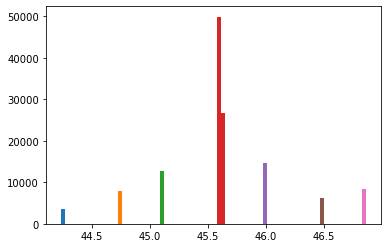

In [20]:
# Histogram of E_lep for all seven classes
i = ind['E_lep']
to_draw = (lep_data[1][:,i], lep_data[2][:,i], lep_data[3][:,i], lep_data[4][:,i], lep_data[5][:,i], lep_data[6][:,i], lep_data[7][:,i])
plt.hist(to_draw, bins=80, histtype='stepfilled');

In [21]:
# Calculate cms energies
#sqrts = {}
sqrts = np.zeros(7)
for i in range(7):
    #sqrts[i] = lep_data[i][:,ind['E_lep']].mean() * 2
    sqrts[i] = lep_data[i+1][:,ind['E_lep']].mean() * 2
print('cms energies measured at:')
print(sqrts)

cms energies measured at:
[88.4761 89.4669 90.2202 91.229  91.9646 92.9618 93.7136]


In [22]:
# Filter measured data and apply efficiency matrix
N_filtered = np.zeros((7,4))
N_real = np.zeros((7,4))
for i in range(7):
    d = lep_data[i+1]
    N_filtered[i] = np.array([
        len(list(filter(select_ee, d))),
        len(list(filter(select_mm, d))),
        len(list(filter(select_tt, d))),
        len(list(filter(select_qq, d))),
    ])
    N_real[i] = np.dot(eff_inv, N_filtered[i])
    
# calculate errors after applying efficicency matrix
N_real_err_syst = np.zeros((7,4))
N_real_err_stat = np.zeros((7,4))
N_real_err = np.zeros((7,4))
for i in range(7):
    for j in range(4):
        N_real_err_syst[i,j] = N_filtered[i,j] * eff_inv_err[j,j]
        N_real_err_stat[i,j] = np.sqrt(N_filtered[i,j]) * eff_inv[j,j]
        N_real_err[i,j] = np.sqrt(N_real_err_syst[i,j]**2 + N_real_err_stat[i,j]**2)

print('Number of events (filtered):')
print(N_filtered)
print('Real number of events (applied efficency matrix):')
print(N_real)
print('Error for real number of events:')
print(N_real_err)

Number of events (filtered):
[[   39.    77.    26.  2043.]
 [  100.   225.    48.  5242.]
 [  158.   418.   100.  9354.]
 [  820.  2697.   575. 60810.]
 [  138.   510.   111. 11657.]
 [   50.   187.    55.  4620.]
 [   92.   245.    65.  5963.]]
Real number of events (applied efficency matrix):
[[  114.6362    83.9654   121.5564  2106.9011]
 [  296.3902   246.8081   176.0319  5406.6655]
 [  465.77     457.7778   417.7744  9647.296 ]
 [ 2417.1917  2957.8999  2172.4671 62719.5299]
 [  405.7714   559.2438   422.1605 12023.0185]
 [  145.3145   204.3055   247.2238  4764.6483]
 [  270.6217   268.0645   275.6821  6149.9221]]
Error for real number of events:
[[ 18.7331   9.6826  36.9582  46.6501]
 [ 30.0576  16.5529  50.2596  74.7634]
 [ 37.8542  22.564   72.6913  99.9366]
 [ 88.0972  57.3864 177.5114 256.8937]
 [ 35.354   24.925   76.6179 111.6038]
 [ 21.2188  15.0902  53.8145  70.1808]
 [ 28.8226  17.2731  58.5254  79.7486]]


In [23]:
# Calculate cross-section
luminosities = [403.1200, 545.0066, 542.7271, 2080.004, 493.6100, 340.7600, 622.4900]
rad_correction_lep = [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]
rad_correction_had = [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6]
rad_correction = np.zeros((7,4))
for i in range(3):
    rad_correction[:,i] = rad_correction_lep
rad_correction[:,3] = rad_correction_had

cross_section = np.zeros((7,4))
for i in range(7):
    for j in range(4):
        cross_section[i][j] = N_real[i][j] / luminosities[i] + rad_correction[i,j]

print('Cross sections for ee, mm, tt, qq for the 7 measured cms energies')
print(cross_section)
np.savetxt('2_cross_sections.csv', cross_section, delimiter=',')

Cross sections for ee, mm, tt, qq for the 7 measured cms energies
[[ 0.3744  0.2983  0.3915  7.2265]
 [ 0.7438  0.6529  0.523  14.2204]
 [ 1.2182  1.2035  1.1298 25.4756]
 [ 1.6821  1.9421  1.5645 40.9536]
 [ 1.042   1.353   1.0753 29.0573]
 [ 0.4164  0.5896  0.7155 13.7824]
 [ 0.3547  0.3506  0.3629  8.2796]]


In [24]:
# Calculate errors for cross sections
luminosities_err_stat = [2.702073, 3.174455, 3.200826, 6.346789, 3.126548, 2.630305, 3.579958]
luminosities_err_syst = [2.700000, 3.650900, 3.637500, 13.92980, 3.302000, 2.284000, 4.180000]

cross_section_err_stat = np.zeros((7,4))
cross_section_err_syst = np.zeros((7,4))
cross_section_err = np.zeros((7,4))
for i in range(7):
    for j in range(4):
        cross_section_err_stat[i,j] = cross_section[i,j] * np.sqrt((N_real_err_stat[i,j]/N_real[i,j])**2 + (luminosities_err_stat[i]/luminosities[i])**2)
        cross_section_err_syst[i,j] = cross_section[i,j] * (- luminosities_err_syst[i] / luminosities[i] + N_real_err_syst[i,j] / N_real[i,j])
        cross_section_err[i,j] = np.sqrt(cross_section_err_syst[i,j]**2 + cross_section_err_stat[i,j]**2)
        
print("Statistischer Fehler:")
print(cross_section_err_stat)
print("Systematische Fehler:")
print(cross_section_err_syst)
print("Gesamtfehler:")
print(cross_section_err)
print(cross_section)
np.savetxt('2_cross_sections_error.csv', cross_section_err, delimiter=',')

Statistischer Fehler:
[[0.0611 0.0345 0.119  0.1671]
 [0.0753 0.0439 0.1491 0.2132]
 [0.0988 0.0597 0.1959 0.3033]
 [0.0599 0.0381 0.1251 0.2079]
 [0.0906 0.0609 0.1944 0.3261]
 [0.0608 0.0438 0.1555 0.2291]
 [0.0377 0.0227 0.0769 0.1174]]
Systematische Fehler:
[[ 0.0006 -0.0017  0.0028 -0.0443]
 [ 0.0012 -0.0037  0.0057 -0.0872]
 [ 0.0019 -0.0068  0.0098 -0.1563]
 [ 0.0027 -0.011   0.0161 -0.2511]
 [ 0.0017 -0.0076  0.011  -0.1779]
 [ 0.0007 -0.0033  0.0054 -0.0846]
 [ 0.0006 -0.002   0.0031 -0.0509]]
Gesamtfehler:
[[0.0612 0.0345 0.119  0.1729]
 [0.0753 0.0441 0.1492 0.2304]
 [0.0988 0.0601 0.1962 0.3412]
 [0.06   0.0396 0.1262 0.326 ]
 [0.0906 0.0614 0.1947 0.3715]
 [0.0608 0.0439 0.1556 0.2442]
 [0.0377 0.0228 0.0769 0.1279]]
[[ 0.3744  0.2983  0.3915  7.2265]
 [ 0.7438  0.6529  0.523  14.2204]
 [ 1.2182  1.2035  1.1298 25.4756]
 [ 1.6821  1.9421  1.5645 40.9536]
 [ 1.042   1.353   1.0753 29.0573]
 [ 0.4164  0.5896  0.7155 13.7824]
 [ 0.3547  0.3506  0.3629  8.2796]]


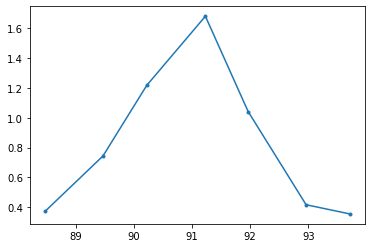

In [25]:
# Plot of the cross sections for j (0: electrons, 1: muon, 2: tau, 3: quarks)
i = ind['E_lep']
j = 0
plt.plot(sqrts, cross_section[:,j], marker='.')

In [28]:
# Calculate mm in [-1,0] and [0,1] for A_FB

data_mm_selected = list(filter(select_mm, lep_data[4]))
forward_events = len(list(filter(lambda x: x[ind['cos_thet']] >= 0, data_mm_selected)))
backwards_events = len(list(filter(lambda x: x[ind['cos_thet']] < 0, data_mm_selected)))
N_f_err_stat = np.sqrt(forward_events)
N_b_err_stat = np.sqrt(backwards_events)
print('Events in [0,1]:', len(list(filter(lambda x: x[ind['cos_thet']] >= 0, data_mm_selected))))
print('Events in [-1,0):', len(list(filter(lambda x: x[ind['cos_thet']] < 0, data_mm_selected))))
A = (forward_events - backwards_events)/(forward_events + backwards_events)
err_A = 1 / (forward_events + backwards_events)**2 * np.sqrt((2 * backwards_events * N_f_err_stat)**2 + (2 * forward_events * N_b_err_stat)**2)
print('Forward-Backwards-Asymmetry: ', A)
print('Error for A: ', err_A)
sin_thet_w_2 = 0.25 - np.sqrt(A/48)
err_sin_thet_w_2 = 1/(8 * np.sqrt(3 * A)) * err_A
print('Weinberg angle: ', sin_thet_w_2)
print('Error for weinberg angle:', err_sin_thet_w_2)

Events in [0,1]: 1361
Events in [-1,0): 1336
Forward-Backwards-Asymmetry:  0.009269558769002595
Error for A:  0.019254882274127732
Weinberg angle:  0.23610338862572772
Error for weinberg angle: 0.014433136608168286
